<a href="https://colab.research.google.com/github/souvik25162/ArimaAnnHybrid/blob/master/Bayesian_Sarima%2Blstm_Sweden.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Step1:

#Update pymc3

In [1]:
!pip install pymc3==3.8

     |████████████████████████████████| 911kB 4.2MB/s 
     |████████████████████████████████| 1.6MB 34.8MB/s 
     |████████████████████████████████| 4.7MB 44.4MB/s 
     |████████████████████████████████| 737kB 40.6MB/s 
     |████████████████████████████████| 327kB 53.7MB/s 
  Found existing installation: xarray 0.15.1
    Uninstalling xarray-0.15.1:
      Successfully uninstalled xarray-0.15.1
  Found existing installation: pymc3 3.7
    Uninstalling pymc3-3.7:
      Successfully uninstalled pymc3-3.7


In [2]:
!pip install arviz==0.6.1

     |████████████████████████████████| 1.4MB 4.2MB/s 
  Found existing installation: arviz 0.11.0
    Uninstalling arviz-0.11.0:
      Successfully uninstalled arviz-0.11.0


#Required Packages for Arima &Sarimax

In [3]:
%matplotlib inline
import theano
import theano.tensor as tt
import pymc3 as pm
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
from pandas_datareader.data import DataReader
from pandas.plotting import register_matplotlib_converters
plt.style.use('seaborn')
register_matplotlib_converters()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Sweden Unempoyment dataset

In [7]:
from google.colab import files
uploaded= files.upload()
df=pd.read_csv('sweden.csv')
df.rename(columns={'LRHUTTTTSEM156S':'values'},inplace=True)
print(df.shape)

Saving sweden.csv to sweden (2).csv
(432, 2)


In [8]:
df.head()

,DATE,values
0,1983-01-01,3.4
1,1983-02-01,3.7
2,1983-03-01,3.7
3,1983-04-01,3.4
4,1983-05-01,3.7


In [9]:
df.index= pd.to_datetime(df.pop('DATE'))

In [10]:
training_datalen=len(df)-36

In [11]:
ts=df.values
train=ts[0:training_datalen]
test= ts[training_datalen:len(ts)]

In [12]:
df.head()

,values
DATE,
1983-01-01,3.4
1983-02-01,3.7
1983-03-01,3.7
1983-04-01,3.4
1983-05-01,3.7


In [13]:
inf=df

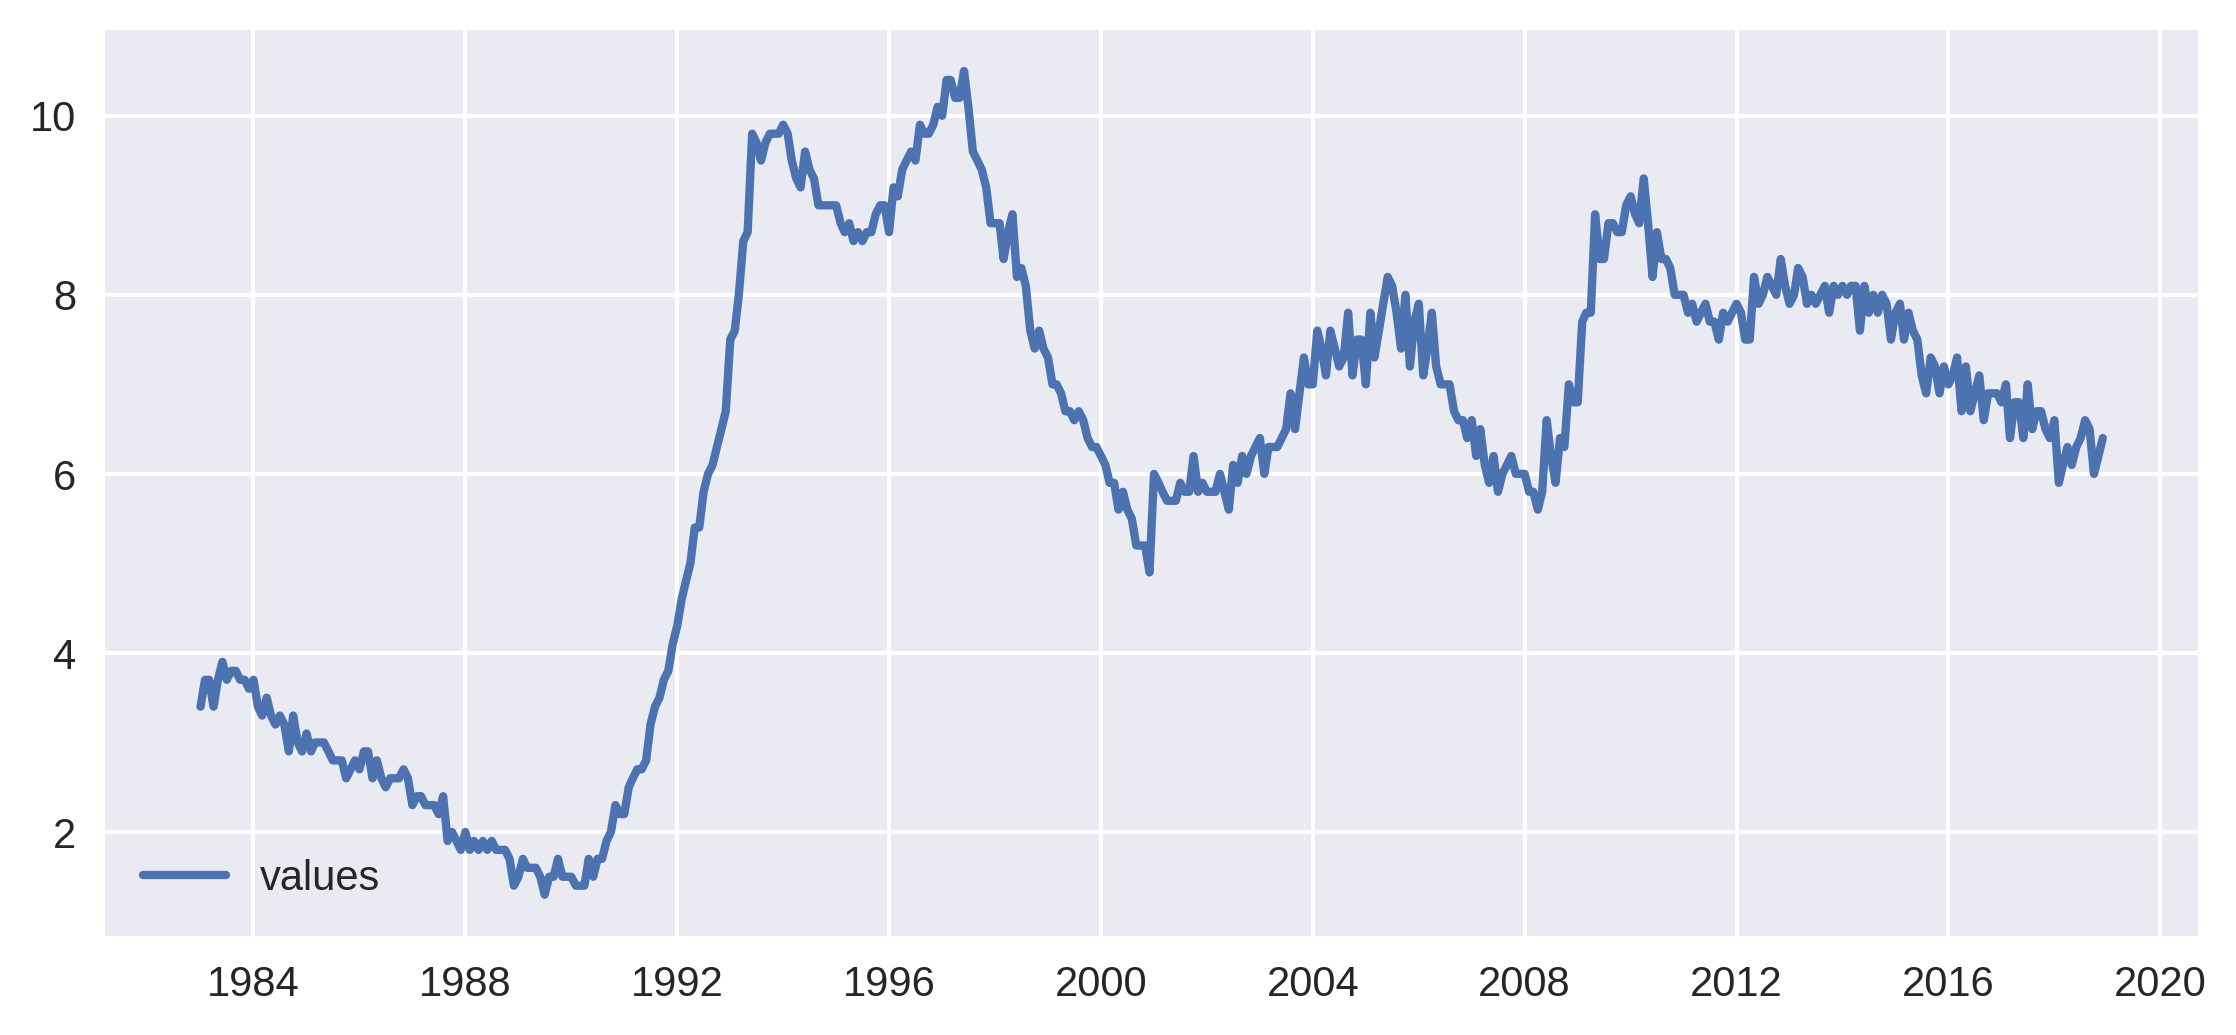

In [14]:
fig, ax = plt.subplots(figsize=(9, 4), dpi=300)
ax.plot(inf.index, inf, label=r'values', lw=2)
ax.legend(loc='lower left')
plt.show()

#Basic arima Model with p=1 & q=1

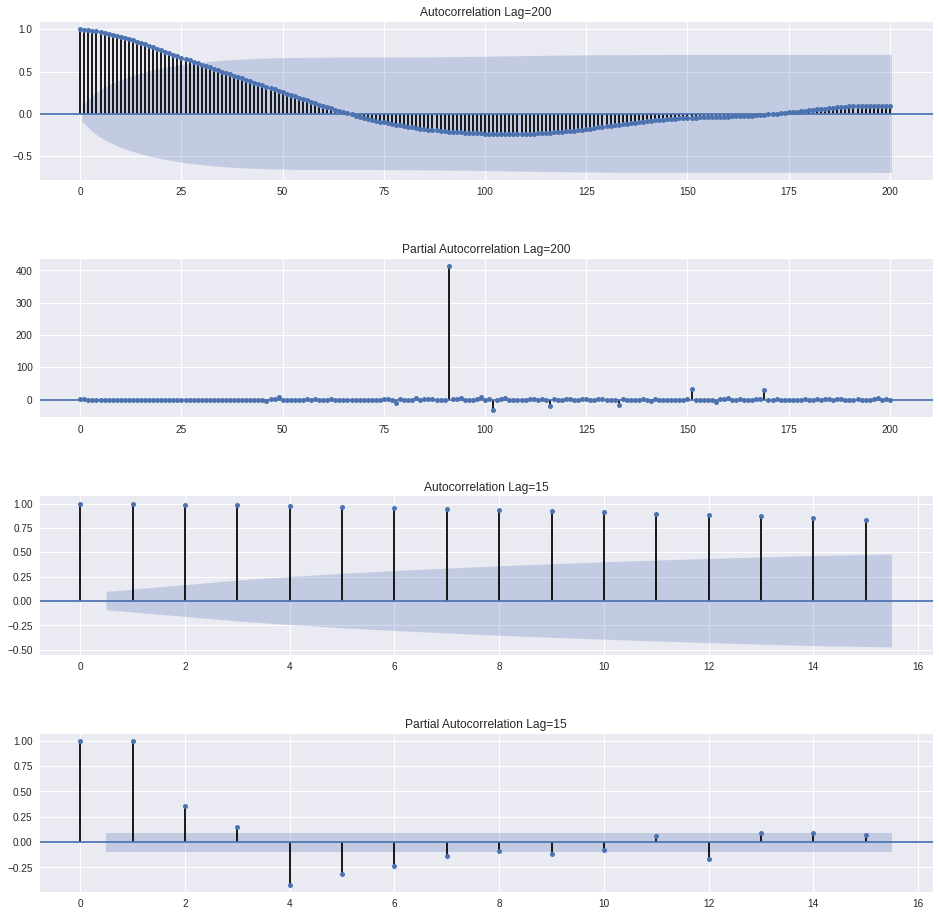

In [15]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
fig = plt.figure(figsize=(16,16))
ax1 = fig.add_subplot(411)
fig = plot_acf(df['values'],lags=200,ax=ax1)
plt.title('Autocorrelation Lag=200')
ax2 = fig.add_subplot(412)
fig = plot_pacf(df['values'],lags=200,ax=ax2)
plt.title('Partial Autocorrelation Lag=200')
ax3 = fig.add_subplot(413)
fig = plot_acf(df['values'],lags=15,ax=ax3)
plt.title('Autocorrelation Lag=15')
ax4 = fig.add_subplot(414)
fig = plot_pacf(df['values'],lags=15,ax=ax4)
plt.title('Partial Autocorrelation Lag=15')
plt.subplots_adjust(left=None, bottom=None, right=None, top=None,
                wspace=None, hspace=0.5)
plt.show()

In [16]:
from statsmodels.tsa.stattools import adfuller,acf,pacf

def test_stationarity(series,mlag =None, lag = None,):
    print('ADF Test Result')
    res = adfuller(series, maxlag = mlag, autolag = lag)
    output = pd.Series(res[0:4],index = ['Test Statistic', 'p value', 'used lag', 'Number of observations used'])
    for key, value in res[4].items():
        output['Critical Value ' + key] = value
    print(output)

In [17]:
test_stationarity(df['values'])

ADF Test Result
Test Statistic                  -2.174699
p value                          0.215556
used lag                        18.000000
Number of observations used    413.000000
Critical Value 1%               -3.446283
Critical Value 5%               -2.868564
Critical Value 10%              -2.570511
dtype: float64


In [18]:
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
import warnings
warnings.filterwarnings("ignore")
plt.style.use("fivethirtyeight")
import statsmodels.api as sm
import matplotlib
matplotlib.rcParams['axes.labelsize']=14
matplotlib.rcParams['xtick.labelsize']=12
matplotlib.rcParams['ytick.labelsize']=12
matplotlib.rcParams['text.color']='k'

In [19]:
history=[x for x in train]
predictions=list()

for t in range(len(test)):
  model=ARIMA(history,order=(1,1,1))
  model_fit=model.fit(disp=0)
  output=model_fit.forecast()
  yhat=output[0]
  predictions.append(yhat)
  obs=test[t]
  history.append(obs)
  print('predicted=%f, expected=%f'%(yhat,obs))

predicted=7.139929, expected=7.000000
predicted=7.058426, expected=7.100000
predicted=7.089130, expected=7.300000
predicted=7.257878, expected=6.700000
predicted=6.866329, expected=7.200000
predicted=7.088114, expected=6.700000
predicted=6.840729, expected=6.900000
predicted=6.864757, expected=7.100000
predicted=7.052291, expected=6.600000
predicted=6.746658, expected=6.900000
predicted=6.836509, expected=6.900000
predicted=6.905085, expected=6.900000
predicted=6.910561, expected=6.800000
predicted=6.839125, expected=7.000000
predicted=6.956561, expected=6.400000
predicted=6.578136, expected=6.800000
predicted=6.707069, expected=6.800000
predicted=6.802346, expected=6.400000
predicted=6.525601, expected=7.000000
predicted=6.842171, expected=6.500000
predicted=6.647893, expected=6.700000
predicted=6.660523, expected=6.700000
predicted=6.706247, expected=6.500000
predicted=6.570386, expected=6.400000
predicted=6.444712, expected=6.600000
predicted=6.551914, expected=5.900000
predicted=6.

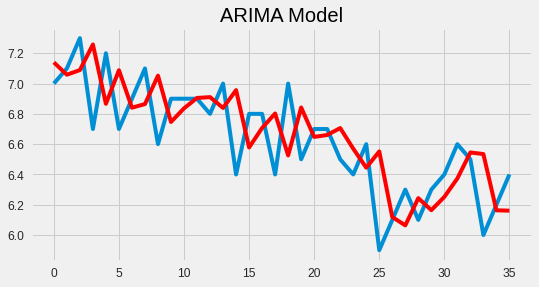

In [20]:
plt.figure(figsize=(8,4))
plt.title("ARIMA Model")
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

In [112]:
from sklearn.metrics import mean_squared_error
error=mean_squared_error(test,predictions)
print("MSE:",error)

print("RMSE:",np.sqrt(error))

MSE: 0.07998800440542696
RMSE: 0.28282150626398084


In [22]:
from sklearn.metrics import mean_absolute_error
error=mean_absolute_error(test,predictions)
print("MAE:",error)

MAE: 0.22340784353568882






#BAYESIAN Arima


In [23]:
inf = df
#inf is the series we will use for analysis
print(inf.head())

            values
DATE              
1983-01-01     3.4
1983-02-01     3.7
1983-03-01     3.7
1983-04-01     3.4
1983-05-01     3.7


In [24]:
mod = sm.tsa.statespace.SARIMAX(inf, order=(1, 1, 1))

In [25]:
class Loglike(tt.Op):

    itypes = [tt.dvector] # expects a vector of parameter values when called
    otypes = [tt.dscalar] # outputs a single scalar value (the log likelihood)

    def __init__(self, model):
        self.model = model
        self.score = Score(self.model)

    def perform(self, node, inputs, outputs):
        theta, = inputs  # contains the vector of parameters
        llf = self.model.loglike(theta)
        outputs[0][0] = np.array(llf) # output the log-likelihood

    def grad(self, inputs, g):
        # the method that calculates the gradients - it actually returns the
        # vector-Jacobian product - g[0] is a vector of parameter values
        theta, = inputs  # our parameters
        out = [g[0] * self.score(theta)]
        return out


class Score(tt.Op):
    itypes = [tt.dvector]
    otypes = [tt.dvector]

    def __init__(self, model):
        self.model = model

    def perform(self, node, inputs, outputs):
        theta, = inputs
        outputs[0][0] = self.model.score(theta)

In [26]:
# Set sampling params
ndraws = 6000  # number of draws from the distribution
nburn = 1000  # number of "burn-in points" (which will be discarded)

In [27]:
loglike = Loglike(mod)

In [28]:
with pm.Model():
    # Priors
    arL1 = pm.Uniform('ar.L1', -1, 1)
    maL1 = pm.Uniform('ma.L1', -1, 1)
    sigma2 = pm.InverseGamma('sigma2', 2, 4)

    # convert variables to tensor vectors
    theta = tt.as_tensor_variable([arL1, maL1, sigma2])

    # use a DensityDist (use a lamdba function to "call" the Op)
    pm.DensityDist('likelihood', lambda v: loglike(v), observed={'v': theta})

    # Draw samples
    trace = pm.sample(ndraws, tune=nburn, discard_tuned_samples=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma2, ma.L1, ar.L1]
Sampling chain 1, 0 divergences: 100%|██████████| 7000/7000 [04:33<00:00, 25.61it/s]


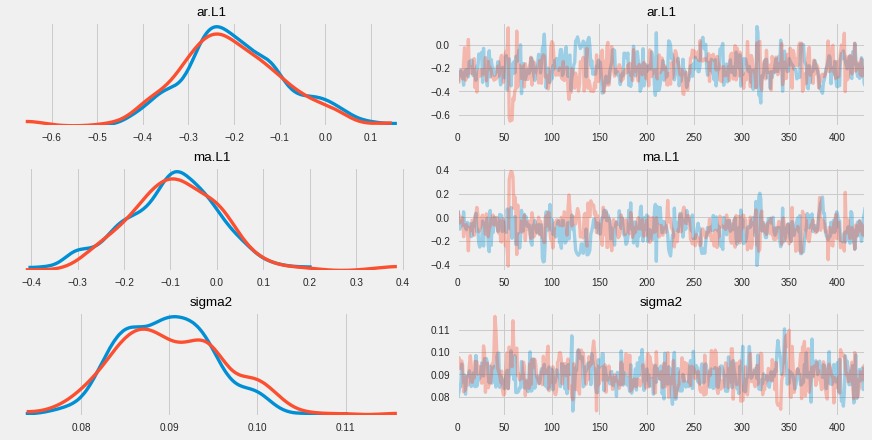

In [29]:
import arviz as az
axes = az.plot_trace(trace[0:len(ts)-1])
fig = axes.ravel()[0].figure

The NUTS sampler is auto-assigned because we provided gradients. PyMC3 will use Metropolis or Slicing samplers if it does not find that gradients are available. There are an impressive number of draws per second for a “block box” style computation! However, note that if the model can be represented directly by PyMC3 (like the AR(p) models mentioned above), then computation can be substantially faster.

Inference is complete, but are the results any good? There are a number of ways to check. The first is to look at the posterior distributions (with lines showing the MLE values):

In [ ]:
plt.tight_layout()
pm.traceplot(trace,
                 lines=[(k, {}, [v]) for k, v in dict(res_mle.params).items()],
                 combined=True,
                 figsize=(12, 12))

In [33]:
pm.summary(trace)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
ar.L1,-0.210,0.107,-0.407,-0.006,0.002,0.001,4358.0,4358.0,4382.0,4957.0,1.0
ma.L1,-0.089,0.099,-0.277,0.096,0.001,0.001,4465.0,4215.0,4496.0,4997.0,1.0
sigma2,0.090,0.006,0.078,0.101,0.000,0.000,6178.0,6129.0,6231.0,5893.0,1.0


R^  is the Gelman-Rubin statistic. It tests for lack of convergence by comparing the variance between multiple chains to the variance within each chain. If convergence has been achieved, the between-chain and within-chain variances should be identical. for all model parameters, we can have some confidence that convergence has been reached if R-hat<1.2



In [ ]:
params = pm.summary(trace)['mean'].values

# Construct results using these posterior means as parameter values
res_bayes = mod.smooth(params)

predict_bayes = res_bayes.get_prediction()
predict_bayes_ci = predict_bayes.conf_int()
lower = predict_bayes_ci['lower values']
upper = predict_bayes_ci['upper values']

# Graph
fig, ax = plt.subplots(figsize=(9,4), dpi=300)

# Plot data points
inf.plot(ax=ax, style='-', label='Observed')

# Plot predictions
predict_bayes.predicted_mean.plot(ax=ax, style='r.', label='One-step-ahead forecast')
ax.fill_between(predict_bayes_ci.index, lower, upper, color='r', alpha=0.1)
ax.legend(loc='lower left')
plt.show()

In [35]:
predict_bayes_output = predict_bayes.predicted_mean

In [36]:
pred_bayes=predict_bayes_output[training_datalen:len(predict_bayes_output)]

#Rmse for bayesian model

In [37]:
from sklearn.metrics import mean_squared_error
error2=mean_squared_error(test,pred_bayes)
print("MSE:",error2)

print("RMSE:",np.sqrt(error2))

MSE: 0.07776644168684974
RMSE: 0.27886635094046347


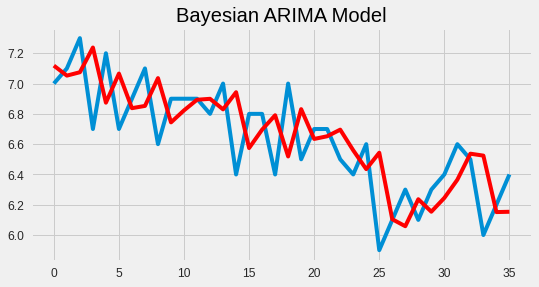

In [38]:
plt.figure(figsize=(8,4))
plt.title("Bayesian ARIMA Model")
plt.plot(test)
plt.plot(pred_bayes.values, color='red')
plt.show()

#Lstm

In [41]:
import keras
from keras.layers import Dense,Dropout,LSTM
from keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler,StandardScaler
plt.style.use('fivethirtyeight')
import tensorflow as tf

In [42]:
data=df.filter(['values'])
dataset=data.values
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
scaled_data=scaler.fit_transform(dataset)

In [43]:
train_data= scaled_data[0:training_datalen,:]
time_step=30
test_data= scaled_data[training_datalen-time_step:,:]

In [44]:
training_datalen=len(df)-36

x_train=[]
y_train=[]
for i in range(time_step,len(train_data)):
  x_train.append(train_data[i-time_step:i,0])
  y_train.append(train_data[i,0])
  if i<=time_step:
    print(x_train)
    print(y_train)
    print()

[array([0.22826087, 0.26086957, 0.26086957, 0.22826087, 0.26086957,
       0.2826087 , 0.26086957, 0.27173913, 0.27173913, 0.26086957,
       0.26086957, 0.25      , 0.26086957, 0.22826087, 0.2173913 ,
       0.23913043, 0.2173913 , 0.20652174, 0.2173913 , 0.20652174,
       0.17391304, 0.2173913 , 0.18478261, 0.17391304, 0.19565217,
       0.17391304, 0.18478261, 0.18478261, 0.18478261, 0.17391304])]
[0.16304347826086957]



In [83]:
x_train=np.array(x_train)
y_train=np.array(y_train)

In [84]:
x_train= np.reshape(x_train,(x_train.shape[0],x_train.shape[1],1))

In [85]:
print(x_train.shape)

(366, 30, 1)


In [86]:
model=Sequential()
model.add(LSTM(units=50,return_sequences=True,input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50,return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

In [87]:
model.compile(optimizer='adam',loss='mean_squared_error')

In [95]:
model.fit(x_train,y_train,batch_size=10,epochs=30)

Epoch 1/30
37/37 [==============================] - 1s 19ms/step - loss: 8.1961e-04
Epoch 2/30
37/37 [==============================] - 1s 19ms/step - loss: 8.2620e-04
Epoch 3/30
37/37 [==============================] - 1s 20ms/step - loss: 8.2888e-04
Epoch 4/30
37/37 [==============================] - 1s 20ms/step - loss: 0.0010
Epoch 5/30
37/37 [==============================] - 1s 20ms/step - loss: 9.1272e-04
Epoch 6/30
37/37 [==============================] - 1s 19ms/step - loss: 9.3174e-04
Epoch 7/30
37/37 [==============================] - 1s 20ms/step - loss: 8.5309e-04
Epoch 8/30
37/37 [==============================] - 1s 20ms/step - loss: 7.9658e-04
Epoch 9/30
37/37 [==============================] - 1s 19ms/step - loss: 9.3945e-04
Epoch 10/30
37/37 [==============================] - 1s 19ms/step - loss: 8.9385e-04
Epoch 11/30
37/37 [==============================] - 1s 19ms/step - loss: 8.0955e-04
Epoch 12/30
37/37 [==============================] - 1s 19ms/step - loss: 7.82

In [96]:
x_test=[]
y_test= dataset[training_datalen:,:]
for i in range(time_step,len(test_data)):
  x_test.append(test_data[i-time_step:i,0])

In [97]:
x_test=np.array(x_test)

In [98]:
x_test=np.reshape(x_test,(x_test.shape[0],x_test.shape[1],1))

In [99]:
pred= model.predict(x_test)
pred1=scaler.inverse_transform(pred)

In [100]:
train= data[:training_datalen]
valid=data[training_datalen:]
valid['pred1']=pred1

No handles with labels found to put in legend.


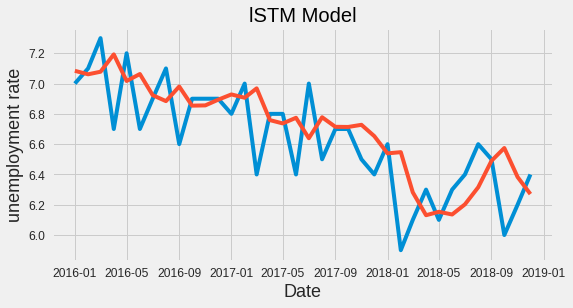

In [76]:
plt.figure(figsize=(8,4))
plt.title("lSTM Model")
plt.xlabel("Date",fontsize=18)
plt.ylabel("unemployment rate",fontsize=18)
plt.plot(valid[['values','pred1']])
plt.legend()
plt.show()

Rmse for LSTM
(can give different results when you run the model multiple times)


In [101]:
from sklearn.metrics import mean_squared_error
error3=mean_squared_error(test,pred1)
print("MSE:",error3)

print("RMSE:",np.sqrt(error3))

MSE: 0.0739057017344963
RMSE: 0.2718560312637855


In [108]:
from sklearn.metrics import mean_absolute_error
error=mean_absolute_error(test,pred1)
print("MAE:",error)

MAE: 0.19991106722089974


for Bayesian Sarima

In [79]:
from sklearn.metrics import mean_squared_error
error2=mean_squared_error(test,pred_bayes)
print("MSE:",error2)

print("RMSE:",np.sqrt(error2))

MSE: 0.07776644168684974
RMSE: 0.27886635094046347


In [40]:
from sklearn.metrics import mean_absolute_error
error=mean_absolute_error(test,pred_bayes)
print("MAE:",error)

MAE: 0.22230794126843723


#Hybridization(Bayesian Sarima +Lstm)

In [103]:
NEW_PREDICTION= (pred1.T+pred_bayes.values)/2

In [104]:
NEW_PREDICTION= np.array(NEW_PREDICTION)

In [63]:
NEW_PREDICTION

array([[3.32185813, 3.33685381, 3.3513504 , 3.36276905, 3.36741998,
        3.36481586, 3.35924215, 3.35365209, 3.34883946, 3.34334563,
        3.33696814, 3.32950113, 3.32053745, 3.31032831, 3.29878986,
        3.2860014 , 3.27241528, 3.25755689, 3.23722332, 3.20960426,
        3.17464594, 3.135045  , 3.0918519 , 3.04832735, 3.00341683,
        2.95268112, 2.89324943, 2.74421288, 2.68098148, 2.61698762,
        2.56956511, 2.53901913, 2.5172371 , 2.49674349, 2.47405082,
        2.44906686]])

In [64]:
pred_bayes.values

array([3.30370966, 3.31757345, 3.33060999, 3.33976254, 3.34059625,
       3.33456593, 3.32950224, 3.32781763, 3.32733524, 3.32363079,
       3.31684081, 3.30796857, 3.29753447, 3.28659476, 3.27490424,
       3.26225104, 3.24902416, 3.23411673, 3.21100055, 3.17907522,
       3.14054401, 3.10052766, 3.05907596, 3.01931577, 2.97692954,
       2.92431556, 2.85958726, 2.65706447, 2.63739029, 2.60341294,
       2.57609854, 2.55357556, 2.52675278, 2.49265848, 2.45533168,
       2.42066856])

In [65]:
test.shape

(36, 1)

In [66]:
NEW_PREDICTION.shape

(1, 36)

In [67]:
pred1.shape

(36, 1)

In [105]:
from sklearn.metrics import mean_squared_error
error=mean_squared_error(test,NEW_PREDICTION.T)
print("MSE:",error)

print("RMSE:",np.sqrt(error))

MSE: 0.0724535414320071
RMSE: 0.2691719551365021


In [109]:
from sklearn.metrics import mean_absolute_error
error=mean_absolute_error(test,NEW_PREDICTION.T)
print("MAE:",error)

MAE: 0.2048403043925155


#Sarima+LSTM

In [70]:
pred1

array([[3.3400066],
       [3.3561342],
       [3.3720908],
       [3.3857756],
       [3.3942437],
       [3.3950658],
       [3.388982 ],
       [3.3794866],
       [3.3703437],
       [3.3630605],
       [3.3570955],
       [3.3510337],
       [3.3435404],
       [3.3340619],
       [3.3226755],
       [3.3097517],
       [3.2958064],
       [3.280997 ],
       [3.263446 ],
       [3.2401333],
       [3.2087479],
       [3.1695623],
       [3.1246278],
       [3.077339 ],
       [3.0299041],
       [2.9810467],
       [2.9269116],
       [2.8313613],
       [2.7245727],
       [2.6305623],
       [2.5630317],
       [2.5244627],
       [2.5077214],
       [2.5008285],
       [2.49277  ],
       [2.4774652]], dtype=float32)

In [71]:
pred

array([[0.6097448 ],
       [0.6128404 ],
       [0.61590326],
       [0.61853004],
       [0.62015545],
       [0.6203132 ],
       [0.6191455 ],
       [0.61732286],
       [0.6155679 ],
       [0.6141699 ],
       [0.61302495],
       [0.6118614 ],
       [0.6104231 ],
       [0.6086037 ],
       [0.60641813],
       [0.60393745],
       [0.60126066],
       [0.59841806],
       [0.5950492 ],
       [0.5905744 ],
       [0.58455   ],
       [0.57702845],
       [0.5684034 ],
       [0.5593264 ],
       [0.55022144],
       [0.54084337],
       [0.5304523 ],
       [0.51211166],
       [0.49161386],
       [0.47356886],
       [0.46060655],
       [0.45320332],
       [0.44998989],
       [0.44866678],
       [0.44711998],
       [0.44418228]], dtype=float32)

In [110]:
NEW_PREDICTION2= (pred1+predictions)/2

In [ ]:
NEW_PREDICTION2

In [111]:
from sklearn.metrics import mean_squared_error
error=mean_squared_error(test,NEW_PREDICTION2)
print("MSE:",error)

print("RMSE:",np.sqrt(error))

MSE: 0.0737933754392317
RMSE: 0.2716493611979084


In [113]:
from sklearn.metrics import mean_absolute_error
error=mean_absolute_error(test,NEW_PREDICTION2)
print("MAE:",error)

MAE: 0.20599292535431635
